# Titanic dataset

## Load data and packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder

data_df = pd.read_csv('./data/train.csv')
test_df = pd.read_csv('./data/test.csv')

joint_df = data_df.append(test_df)

joint_df['Embarked'] = joint_df['Embarked'].fillna(joint_df['Embarked'].value_counts().index[0])
joint_df['Fare'] = joint_df['Fare'].fillna(joint_df[joint_df['Pclass'] == 3]['Fare'].mean())

joint_df['Embarked'] = joint_df['Embarked'].map( {'S' : 0, 'C' : 1, 'Q': 2} ).astype(int)
joint_df['Sex'] = joint_df['Sex'].map( {'male': 0, 'female' : 1} ).astype(int)

print(joint_df.isnull().sum())

Age             263
Cabin          1014
Embarked          0
Fare              0
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64


C:\Users\oskar\Anaconda3\envs\machine_learning\lib\site-packages\pandas\core\frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


# Add/Change variables

## Cabin -> Cabin deck
Change cabin to the number of the deck it was in or missing if it is unknown

In [2]:
cabins = joint_df[joint_df['Cabin'].notnull()]['Cabin'].to_numpy()
cabin_deck = []
for cabin in cabins:
    cabin_deck.append(cabin[0])
cabins = joint_df['Cabin'].fillna('Missing').to_numpy()
cabins[cabins != 'Missing'] = cabin_deck
joint_df['Cabin'] = cabins
joint_df['Cabin'] = joint_df['Cabin'].map( {'Missing' : 0, 'T' : 0, 'A': 1, 'G' : 1, 'F' : 1, 'B' : 2, 'C' : 2, 'D': 2, 'E': 2} )

joint_df.head()
joint_df.dtypes

Age            float64
Cabin            int64
Embarked         int32
Fare           float64
Name            object
Parch            int64
PassengerId      int64
Pclass           int64
Sex              int32
SibSp            int64
Survived       float64
Ticket          object
dtype: object

In [3]:
pd.crosstab(joint_df['Cabin'], joint_df['Survived'])

Survived,0.0,1.0
Cabin,,
0,482,206
1,15,17
2,52,119


## Name -> Title

In [4]:
joint_df['Title'] = joint_df['Name'].str.extract(' ([A-Za-z]+)\.', expand = False)    
    
pd.crosstab(joint_df['Title'], joint_df['Sex'])

Sex,0,1
Title,,
Capt,1,0
Col,4,0
Countess,0,1
Don,1,0
Dona,0,1
Dr,7,1
Jonkheer,1,0
Lady,0,1
Major,2,0


In [5]:
joint_df['Title'] = joint_df['Title'].replace(['Capt', 'Col', 'Countess', 'Don', 'Dr', 'Jonkheer', 'Lady', 'Major', 'Dona', 'Rev', 'Sir'], 'Rare')
joint_df['Title'] = joint_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
joint_df['Title'] = joint_df['Title'].replace('Mme', 'Mrs')
    
joint_df['Title'] = joint_df['Title'].map( {'Miss' : 0, 'Mrs' : 1, 'Mr' : 2, 'Master': 3, 'Rare': 4} )
joint_df.drop(['Name', 'Ticket'], axis = 1, inplace = True)
joint_df[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,0,0.702703
1,1,0.793651
2,2,0.156673
3,3,0.575000
4,4,0.347826


## SibSP and Parch -> Family

In [6]:
joint_df['Family'] = joint_df['SibSp'] + joint_df['Parch']
joint_df['Family'].values[joint_df['Family'].values > 4] = 5

joint_df[['Family', 'Survived']].groupby(['Family'], as_index=False).mean()

,Family,Survived
0,0,0.303538
1,1,0.552795
2,2,0.578431
3,3,0.724138
4,4,0.200000
5,5,0.148936


## Create age categories

In [7]:
joint_df.loc[joint_df['Age'] <= 15, 'Age'] = 0
joint_df.loc[(joint_df['Age'] > 15) & (joint_df['Age'] <= 30), 'Age'] = 1
joint_df.loc[(joint_df['Age'] > 30) & (joint_df['Age'] <= 45), 'Age'] = 2
joint_df.loc[(joint_df['Age'] > 45) & (joint_df['Age'] <= 60), 'Age'] = 3
joint_df.loc[(joint_df['Age'] > 60), 'Age'] = 4

# Replace Null Values

In [8]:
#joint_df[['Pclass', 'Age', 'Sex']].groupby(['Pclass'], as_index = False).mean().sort_values(by = 'Age')#
#
#avg_age = {}
#for pclass in '123':
#    for sex in '01':
#        x = np.logical_and(joint_df['Pclass'] == int(pclass), joint_df['Sex'] == int(sex))       
#        mean = joint_df[x]['Age'].mean()
#        joint_df.loc[x, 'Age'] = joint_df.loc[x, 'Age'].fillna(mean)

from sklearn.neighbors import KNeighborsClassifier

null_age = joint_df[joint_df['Age'].isnull()]
known_age = joint_df[joint_df['Age'].notnull()]

knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(known_age[['Sex', 'Pclass', 'Parch', 'SibSp', 'Title', 'Fare']], known_age['Age'])
predicted_ages = knn.predict(null_age[['Sex', 'Pclass', 'Parch', 'SibSp', 'Title', 'Fare']])

joint_df.loc[joint_df['Age'].isnull(), 'Age'] = predicted_ages

# Training/Validation/Training Split

In [9]:
from sklearn.model_selection import train_test_split
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'Family']

data_df = joint_df.loc[joint_df['Survived'].notnull()]
test_df = joint_df.loc[joint_df['Survived'].isnull()]

data_df = data_df.astype({'Survived': np.int32})
test_df.drop('Survived', axis = 1, inplace = True)

train_df, val_df = train_test_split(data_df)
train_X = train_df[features]
train_y = train_df['Survived']

val_X = val_df[features]
val_y = val_df['Survived']

data_X = data_df[features]
data_y = data_df['Survived']

test_X = test_df[features]

data_df

C:\Users\oskar\Anaconda3\envs\machine_learning\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Age,Cabin,Embarked,Fare,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Title,Family
0,1.0,0,0,7.2500,0,1,3,0,1,0,2,1
1,2.0,2,1,71.2833,0,2,1,1,1,1,1,1
2,1.0,0,0,7.9250,0,3,3,1,0,1,0,0
3,2.0,2,0,53.1000,0,4,1,1,1,1,1,1
4,2.0,0,0,8.0500,0,5,3,0,0,0,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,1.0,0,0,13.0000,0,887,2,0,0,0,4,0
887,1.0,2,0,30.0000,0,888,1,1,0,1,0,0
888,1.0,0,0,23.4500,2,889,3,1,1,0,0,3
889,1.0,2,1,30.0000,0,890,1,0,0,1,2,0


# Random Forest Classifier

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, max_depth = 10)
rf.fit(train_X, train_y)
predictions = rf.predict(val_X)

survived = val_y.to_numpy()

print('Prediction accuracy:',np.sum(predictions == survived)/predictions.shape[0])
print(rf.feature_importances_)

Prediction accuracy: 0.8251121076233184
[0.09305151 0.1766821  0.09325665 0.32464111 0.20494706 0.10742156]


## Cross validation

In [11]:
from sklearn.model_selection import cross_val_score

rf = RandomForestClassifier(n_estimators = 1000, max_depth = 10)

print('Cross validation accuracy:', cross_val_score(rf, data_X, data_y, cv = 5).min())
print(data_X.head())

Cross validation accuracy: 0.7921348314606742
   Pclass  Sex  Age     Fare  Title  Family
0       3    0  1.0   7.2500      2       1
1       1    1  2.0  71.2833      1       1
2       3    1  1.0   7.9250      0       0
3       1    1  2.0  53.1000      1       1
4       3    0  2.0   8.0500      2       0


In [12]:
x = 0
n = 10
rf = RandomForestClassifier(n_estimators = 1000, max_depth = 10)
for i in range(0,n):
    print(i/n, end = '\r')
    x += cross_val_score(rf, data_X, data_y, cv = 5).min()
print(x/n)

0.7955056179775282


['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'Family', 'Embarked', 'Parch', 'SibSp', 'Cabin'] : 0.8272744962651434

['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'Family', 'Embarked', 'Cabin'] : 0.8322063900571214

['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'Embarked', 'Parch', 'SibSp', 'Cabin'] : 0.8300797187872699

['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'Family', 'Embarked'] : 0.8314330550499027

['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'Family', 'Cabin'] : 0.8377233067604042

['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'Family'] : 0.8382989140669137

['Pclass', 'Sex', 'Age', 'Fare', 'Title'] : 0.8377402548490366

0.8378513589856256 vs 0.8398694369468332

## Classify on test data using all training data!

In [15]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 1000, max_depth = 10)
rf.fit(data_X, data_y)
predictions = rf.predict(test_X)

pid = test_df['PassengerId'].to_numpy()
submission = pd.DataFrame(np.stack((pid, predictions), axis = -1), columns = ['PassengerId', 'Survived'])
submission.to_csv('./data/rfc_submission.csv', index = False)

# XGBoost

In [16]:
from xgboost import XGBClassifier

train_df, val_df = train_test_split(data_df)
train_X = train_df[features]
train_y = train_df['Survived']

val_X = val_df[features]
val_y = val_df['Survived']


classifier = XGBClassifier(colsample_bylevel= 0.9,
                    colsample_bytree = 0.8, 
                    gamma=0.99,
                    max_depth= 10,
                    min_child_weight= 1,
                    n_estimators= 10,
                    nthread= 4,
                    random_state= 2,
                    silent= True)
classifier.fit(train_X, train_y)
print(classifier.score(val_X, val_y))

0.8565022421524664


In [17]:
predictions = classifier.predict(test_X)

pid = test_df['PassengerId'].to_numpy()
submission = pd.DataFrame(np.stack((pid, predictions), axis = -1), columns = ['PassengerId', 'Survived'])
submission.to_csv('./data/xgb_submission.csv', index = False)

## Classify on test data using all training data!

In [18]:
classifier = XGBClassifier(colsample_bylevel= 0.9,
                    colsample_bytree = 0.8, 
                    gamma=0.99,
                    max_depth= 5,
                    min_child_weight= 1,
                    n_estimators= 10,
                    nthread= 4,
                    random_state= 2,
                    silent= True)
classifier.fit(data_X, data_y)
predictions = classifier.predict(test_X)

pid = test_df['PassengerId'].to_numpy()
submission = pd.DataFrame(np.stack((pid, predictions), axis = -1), columns = ['PassengerId', 'Survived'])
submission.to_csv('./data/xgb_submission.csv', index = False)

# Neural Network

In [19]:
from sklearn.model_selection import train_test_split
features = ['Pclass', 'Sex', 'Age', 'Fare', 'Title', 'Family', 'Embarked', 'Cabin']

data_df = joint_df.loc[joint_df['Survived'].notnull()]
test_df = joint_df.loc[joint_df['Survived'].isnull()]

data_df = data_df.astype({'Survived': np.int32})
test_df.drop('Survived', axis = 1, inplace = True)

train_df, val_df = train_test_split(data_df)
train_X = train_df[features]
train_y = train_df['Survived']

val_X = val_df[features]
val_y = val_df['Survived']

data_X = data_df[features]
data_y = data_df['Survived']

test_X = test_df[features]

C:\Users\oskar\Anaconda3\envs\machine_learning\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
import tensorflow.keras as keras
model = keras.Sequential()
model.add(keras.layers.Dense(units = 12, input_dim = 8, activation = 'relu'))
model.add(keras.layers.Dense(units = 24, activation = 'relu'))
model.add(keras.layers.Dense(units = 32, activation = 'relu'))
model.add(keras.layers.Dense(units = 12, activation = 'relu'))
model.add(keras.layers.Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')

history = model.fit(train_X, train_y, epochs = 200, validation_data = (val_X, val_y), verbose = False)

predictions = np.heaviside(model.predict(val_X) - 0.5, 0).flatten()

survived = val_y.to_numpy()
print('Prediction accuracy:',np.sum(predictions == survived)/predictions.shape[0])

Prediction accuracy: 0.8026905829596412


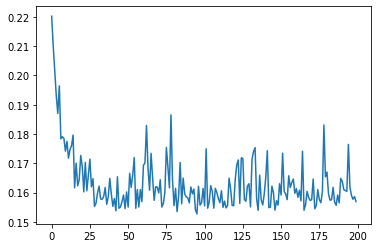

In [26]:
val_loss = np.array(history.history['val_loss'])

plt.plot(np.arange(0, val_loss.shape[0]), val_loss)
plt.show()

In [24]:
model = keras.Sequential()
model.add(keras.layers.Dense(units = 12, input_dim = 8, activation = 'relu'))
model.add(keras.layers.Dense(units = 8, activation = 'relu'))
model.add(keras.layers.Dense(units = 8, activation = 'relu'))
model.add(keras.layers.Dense(units = 8, activation = 'relu'))
model.add(keras.layers.Dense(units = 8, activation = 'relu'))
model.add(keras.layers.Dense(units = 1, activation = 'sigmoid'))

model.compile(loss = 'mean_squared_error', optimizer = 'adam')

history = model.fit(data_X, data_y, epochs = 500, verbose = False)

predictions = np.heaviside(model.predict(test_X) - 0.5, 0).flatten().astype(np.int32)

pid = test_df['PassengerId'].to_numpy()
submission = pd.DataFrame(np.stack((pid, predictions), axis = -1), columns = ['PassengerId', 'Survived'])
submission.to_csv('./data/NN_submission.csv', index = False)